## BAPTA Ca2+ spike detection Ca2+ curves

In [5]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import scipy.ndimage as ndi_sp
from scipy.spatial import cKDTree, distance
from skimage.feature import peak_local_max as peak_local_max_np

import cProfile
import os
import glob
import time
import cv2
import h5py
import napari
import tifffile

In [6]:
def distance(coord_pair1, coord_pair2):
    d = np.sqrt((coord_pair1[0]-coord_pair2[0])**2 + (coord_pair1[1]-coord_pair2[1])**2)
    return d

def remove_neighbours(coords_array, d_lim_px=50):
    remove_idxs = []
    for idx1, coord1 in enumerate(coords_array):
        frame1 = coord1[0]
        coordpair1 = coord1[1:]
        for idx2, coord2 in enumerate(coords_array[idx1+1:-1]):
            idx2 = idx2 + idx1 + 1
            #print([idx1, idx2])
            frame2 = coord2[0]
            coordpair2 = coord2[1:]
            if frame1 == frame2:
                d = distance(coordpair1, coordpair2)
                if d < d_lim_px:
                    remove_idxs.append(idx2)
    remove_idxs = np.unique(remove_idxs)
    if np.size(remove_idxs) > 0:
        coords_array = np.delete(coords_array, remove_idxs, axis=0)
    return coords_array

In [7]:
folder = 'example_data_validationruns'

13h27m06s957871us
(77, 800, 800)
[ 37. 296. 510.]
[ 81. 272. 173.]


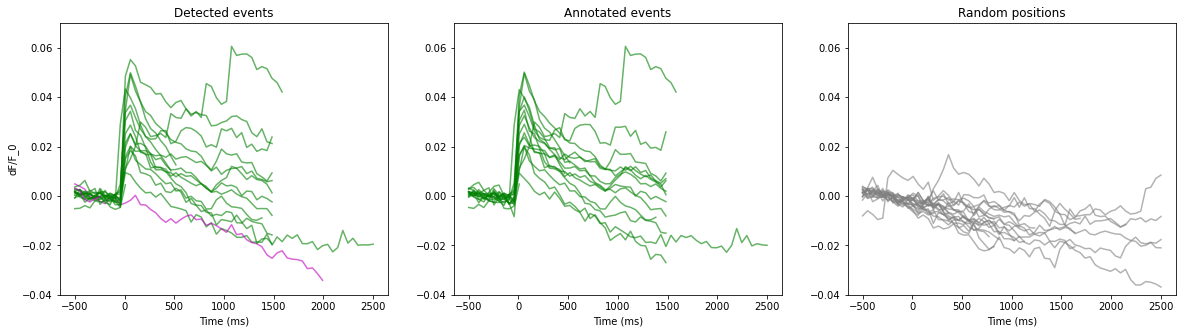

In [18]:
analysisfiles = []
for file in os.listdir(folder):
    if file.endswith('analysiscoords.csv'):
        analysisfiles.append(os.path.join(folder, file))
        
manualfiles = []
for file in os.listdir(folder):
    if file.endswith('manualcoords.csv'):
        manualfiles.append(os.path.join(folder, file))
        
imgfiles = []
for file in os.listdir(folder):
    if file.endswith('Camera.tif'):
        imgfiles.append(os.path.join(folder, file))

d_lim = 5  # um
pxs = 0.1  # um/px
d_lim_px = d_lim/pxs
frame_diff_lim = 2
catrace_pad_pre = 10
catrace_pad_post = 50
radius = 25
lim_signal = 0.4
frame_time = 50  # ms
peak_leniancy = 4

save = False

ylim_lo = -0.04
ylim_hi = 0.07
bin_thresh = 350
    
# load analysis coords
for area, (analysisfile, manualfile, imgfile) in enumerate(zip(analysisfiles, manualfiles, imgfiles)):
    #fig1, axs = plt.subplots(1, 6, figsize=(30,3))
    fig1, axs = plt.subplots(1, 3, figsize=(20,5))
    print(analysisfile.split('_')[2].split('\\')[-1])

    analysiscoords_raw = np.loadtxt(analysisfile, delimiter=',')
    manualcoords_raw = np.loadtxt(manualfile, delimiter=',')

    if np.size(analysiscoords_raw) > 3 and np.size(manualcoords_raw) > 3:
        # remove close-by neighbours to not undercount accuracy/precision - but always compare with the raw instead
        analysiscoords_clean = remove_neighbours(analysiscoords_raw)
        manualcoords_clean = remove_neighbours(manualcoords_raw)
        ## load imgstack for the area
        #f = h5py.File(imgfile, 'r')
        #imgstack = f["data"][...]
        imgstack = tifffile.imread(imgfile)
        print(np.shape(imgstack))

        # calculate binary mask
        img_mean = np.mean(imgstack,0)
        img_bin = ndi_sp.filters.gaussian_filter(img_mean, 2) 
        mask = np.array(img_bin > bin_thresh)

        # compare all analysiscoords to all manualcoords, to check for ~matches, to calculate accuracy
        for analysiscoord in analysiscoords_clean:
            frame_ana = int(analysiscoord[0])
            coordpair_ana = analysiscoord[1:]

            nonlen = False
            # get calcium trace
            frame_start = np.max([0, frame_ana - catrace_pad_pre])
            frame_end = np.min([len(imgstack), frame_ana + catrace_pad_post])
            event_idx = frame_ana - frame_start
            eventstack = np.copy(imgstack[frame_start:frame_end, int(analysiscoord[1]-radius):int(analysiscoord[1]+radius), int(analysiscoord[2]-radius):int(analysiscoord[2]+radius)])
            event_signal = np.array([slice.sum() for slice in eventstack])
            # turn into dF/F_0 signal
            if event_signal.size != 0:
                pre_mean = np.mean(event_signal[:event_idx])
                signal_max = np.max(event_signal)
                event_signal = (event_signal - pre_mean) / pre_mean
                if event_idx != catrace_pad_pre:
                    event_signal = np.pad(event_signal, [catrace_pad_pre-event_idx, 0], mode='constant', constant_values = np.nan)
                if len(event_signal) != catrace_pad_pre+catrace_pad_post:
                    event_signal = np.pad(event_signal, [0, (catrace_pad_pre+catrace_pad_post) - len(event_signal)], mode='constant', constant_values = np.nan)

                for manualcoord in manualcoords_raw:
                    frame_man = manualcoord[0]
                    coordpair_man = manualcoord[1:]
                    if np.abs(frame_ana-frame_man) < frame_diff_lim:
                        d = distance(coordpair_ana, coordpair_man)
                        if d < d_lim_px:
                            if abs(np.argmax(event_signal) - event_idx) < peak_leniancy:
                                plot_color = 'g'
                                plot_idx = 0
                                alpha = 0.6
                            else: 
                                plot_color = 'g'
                                plot_idx = 0
                                alpha = 0.6
                            break
                else:
                    print(analysiscoord)
                    plot_color = 'm'
                    plot_idx = 0
                    alpha = 0.6
                #print(frame_ana)
                axs[plot_idx].plot(np.linspace(-frame_time*catrace_pad_pre, frame_time*catrace_pad_post, catrace_pad_pre+catrace_pad_post), event_signal, plot_color, alpha=alpha)
                #print(analysiscoord)
                #print(np.max(event_signal)*100)



        real_events = 0
        det_real_events = 0
        # compare all manualcoords to all analysiscoords, to check for ~matches, to calculate precision
        for manualcoord in manualcoords_clean:
            frame_man = int(manualcoord[0])
            coordpair_man = manualcoord[1:]

            nonlen = False
            # get calcium trace
            frame_start = np.max([0, frame_man - catrace_pad_pre])
            frame_end = np.min([len(imgstack), frame_man + catrace_pad_post])
            event_idx = frame_man - frame_start
            eventstack = np.copy(imgstack[frame_start:frame_end, int(manualcoord[1]-radius):int(manualcoord[1]+radius), int(manualcoord[2]-radius):int(manualcoord[2]+radius)])
            event_signal = np.array([slice.sum() for slice in eventstack])
            # turn into dF/F_0 signal
            if event_signal.size != 0:
                pre_mean = np.mean(event_signal[:event_idx])
                signal_max = np.max(event_signal)
                event_signal = (event_signal - pre_mean) / pre_mean
                if event_idx != catrace_pad_pre:
                    event_signal = np.pad(event_signal, [catrace_pad_pre-event_idx, 0], mode='constant', constant_values = np.nan)
                if len(event_signal) != catrace_pad_pre+catrace_pad_post:
                    event_signal = np.pad(event_signal, [0, (catrace_pad_pre+catrace_pad_post) - len(event_signal)], mode='constant', constant_values = np.nan)

                for analysiscoord in analysiscoords_raw:
                    frame_ana = analysiscoord[0]
                    coordpair_ana = analysiscoord[1:]
                    if np.abs(frame_man-frame_ana) < frame_diff_lim:
                        d = distance(coordpair_man, coordpair_ana)
                        if d < d_lim_px:
                            if abs(np.argmax(event_signal) - event_idx) < 4:
                                plot_color = 'g'
                                plot_idx = 1
                                alpha = 0.6
                            else: 
                                plot_color = 'g'
                                plot_idx = 1
                                alpha = 0.6
                            break
                else:
                    #print(manualcoord)
                    plot_color = 'm'
                    plot_idx = 1
                    alpha = 0.6
                    print(manualcoord)
                    print(np.max(event_signal)*100)
                #print(frame_man)
                axs[plot_idx].plot(np.linspace(-frame_time*catrace_pad_pre, frame_time*catrace_pad_post, catrace_pad_pre+catrace_pad_post), event_signal, plot_color, alpha=alpha)


        # get traces from random positions in the neurons
        randomframes = np.random.randint(len(imgstack), size=50)
        randomx = np.random.randint(np.shape(imgstack)[1], size=50)
        randomy = np.random.randint(np.shape(imgstack)[1], size=50)
        randomcoords = np.vstack([randomframes, randomx, randomy]).T
        for randomcoord in randomcoords:
            frame_rand = int(randomcoord[0])
            coordpair_rand = randomcoord[1:]
            if mask[int(coordpair_rand[0]),int(coordpair_rand[1])]:
                nonlen = False
                # get calcium trace
                frame_start = np.max([0, frame_rand - catrace_pad_pre])
                frame_end = np.min([len(imgstack), frame_rand + catrace_pad_post])
                event_idx = frame_rand - frame_start
                eventstack = np.copy(imgstack[frame_start:frame_end, int(randomcoord[1]-radius):int(randomcoord[1]+radius), int(randomcoord[2]-radius):int(randomcoord[2]+radius)])
                event_signal = np.array([slice.sum() for slice in eventstack])
                # turn into dF/F_0 signal
                if event_signal.size != 0:
                    pre_mean = np.mean(event_signal[:event_idx])
                    signal_max = np.max(event_signal)
                    event_signal = (event_signal - pre_mean) / pre_mean
                    if event_idx != catrace_pad_pre:
                        event_signal = np.pad(event_signal, [catrace_pad_pre-event_idx, 0], mode='constant', constant_values = np.nan)
                    if len(event_signal) != catrace_pad_pre+catrace_pad_post:
                        event_signal = np.pad(event_signal, [0, (catrace_pad_pre+catrace_pad_post) - len(event_signal)], mode='constant', constant_values = np.nan)

                    plot_color = 'gray'
                    plot_idx = 2
                    alpha = 0.6
                    axs[plot_idx].plot(np.linspace(-frame_time*catrace_pad_pre, frame_time*catrace_pad_post, catrace_pad_pre+catrace_pad_post), event_signal, plot_color, alpha=alpha)


        # set subplot titles
        #titles = ['True positive - single peak', 'True positive - multiple peaks/rising signal', 'False positive', 'Detected events - single peak', 'Detected events - multiple peaks/rising signal', 'False negative']
        titles = ['Detected events', 'Annotated events', 'Random positions']
        for idx_title, title in enumerate(titles):
            axs[idx_title].title.set_text(title)
            if idx_title == 0:
                axs[idx_title].set_ylabel('dF/F_0')
            axs[idx_title].set_ylim([ylim_lo, ylim_hi])
            axs[idx_title].set_xlabel('Time (ms)')

    else:
        print('Less than 2 detected or annotated coords.')
        print('')
            
if save:
    savefolder = folder
    fig1.savefig(os.path.join(savefolder, 'neurons_ca-traces.svg'))